## We charge the Libs

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import kaggle

## we load ours data

In [2]:
train80_df = pd.read_csv('./lmcm/gmsc_train80-v1.2.csv.bz2')
dev20_df = pd.read_csv('./lmcm/gmsc_dev20-v1.2.csv.bz2')
test_df = pd.read_csv('./lmcm/gmsc_test-v1.2.csv.bz2')

## we initialyse the target column

In [3]:
target_column = "SeriousDlqin2yrs"
y_train = train80_df[target_column].values
X_train = train80_df.drop(columns=target_column).values
y_dev = dev20_df[target_column].values
X_dev = dev20_df.drop(columns=target_column).values

## we choose the model

In [4]:
model = XGBClassifier()

## We  fit the model

In [5]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [6]:
y_dev_proba = model.predict_proba(X_dev)[:,1]
print(y_dev_proba[30:40])

[0.00601576 0.03008953 0.04233995 0.0101034  0.00703275 0.03931027
 0.00789118 0.01003646 0.02458931 0.02224318]


## We create fonction for set prediction and count the errors

In [7]:
def set_prediction(threshold):
    return [1 if p> threshold else 0 for p in y_dev_proba]

def count_error(y_dev, y_dev_pred):
    error = []
    for r, p in zip(y_dev, y_dev_pred):
        if (p == 1 and p == r): error.append('TP')
        if (p == 1 and p != r): error.append('FP')
        if (p == 0 and p == r): error.append('TN')
        if (p == 0 and p != r): error.append('FN')
    TP = error.count('TP')
    FP = error.count('FP')
    TN = error.count('TN')
    FN = error.count('FN')
    return TN, FP, FN, TP

## we get prediction in the dev set
* we initialize the threshold
* we use set_prediction
* we count ours dev set errors
* we create the confusion matrix


In [9]:
threshold = 0.5
y_dev_pred = set_prediction(threshold)
TN, FP, FN, TP = count_error(y_dev, y_dev_pred)
confusion_matrix = [[TN,FP],[FN,TP]]
confusion_matrix_df = pd.DataFrame(confusion_matrix)
confusion_matrix_df
#print(f"{y_val_pred.count(1)} {y_val_pred.count(0)} {y_val_pred.count(1)+y_val_pred.count(0)}")

,0,1
0,27830,230
1,1590,350


## We calculate the AUC score

In [10]:
roc_auc_score(y_dev, y_dev_proba)

0.8604381626999582

## We create a fonction for create the ROC curve

In [12]:
def tpr_fpr_lists(nb_thresholds):
    TPR, FPR = [], []
    for i in range(nb_thresholds+1):
        threshold = i/nb_thresholds
        pred = set_prediction(threshold)
        TN, FP, FN, TP = count_error(y_dev, pred)
        TPR.append(TP/(TP+FN))
        FPR.append(FP/(FP+TN))
    return TPR, FPR

TPR, FPR = tpr_fpr_lists(50)

In [13]:
FPR, TPR, thresholds = roc_curve(y_dev, y_dev_proba)

## We diplay the learning curve

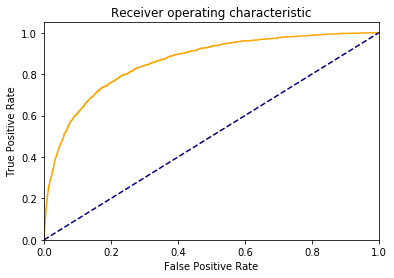

In [14]:
plt.plot(FPR,TPR,color='orange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

## we get the prediction in test set
* we initialize the threshold
* we initialyse ours target column
* we create the prediction
* create a data frame that meets the kaggle specification


In [15]:
threshold = 0.5

y_test = test_df[target_column].values
X_test = test_df.drop(columns=target_column).values

y_test_proba = model.predict_proba(X_test)[:,1]

Id = [int(X_test[i][0]) for i in range(len(X_test))]
d = {'Id': Id, 'Probability': y_test_proba}
kaggle_df = pd.DataFrame(data=d)
kaggle_df

,Id,Probability
0,1,0.061093
1,2,0.046566
2,3,0.015928
3,4,0.053265
4,5,0.091277
...,...,...
101498,101499,0.025317
101499,101500,0.370504
101500,101501,0.006588
101501,101502,0.104818


## we send the file to Kaggle
* We export the Kaggle DataFrame in CSV
* We send the file to Kaggle API

In [17]:
kaggle_df.to_csv('./lmcm/kaggle_sub.csv', index=False)

In [19]:
kaggle.api.competition_submit("./lmcm/kaggle_sub.csv", "XGBClassifier", "GiveMeSomeCredit")

100%|██████████| 1.70M/1.70M [00:04<00:00, 368kB/s] 


Successfully submitted to Give Me Some Credit